## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (90/10) 
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)
    
# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0190  
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4637e-04
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6175e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1051e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9146e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1777e-04
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7415e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5243e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3678e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0356e-04
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8409e-04
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7540e-04
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9110e-04
Epoch 15/100
64/64 ━━━━━━━━━━━━━━

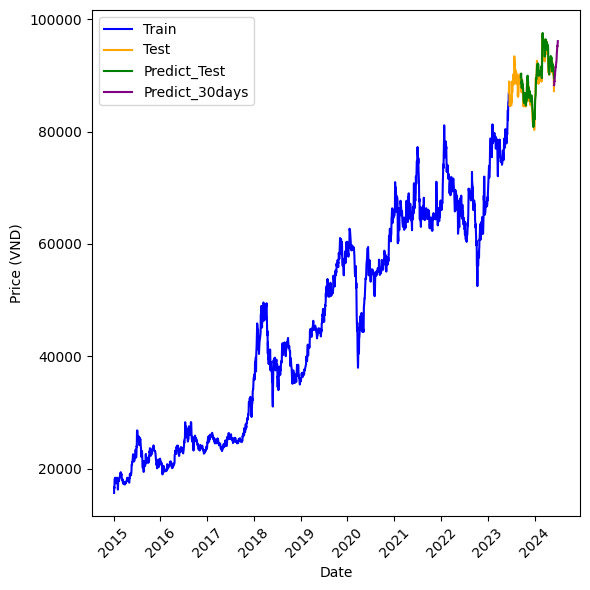

In [2]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('VCB Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                 Forecast
Date                     
2024-06-01   88261.789062
2024-06-02   88308.007812
2024-06-03   88970.476562
2024-06-04   88907.476562
2024-06-05   89040.984375
...                   ...
2024-08-25  113960.828125
2024-08-26  114345.585938
2024-08-27  114669.484375
2024-08-28  114976.671875
2024-08-29  115322.054688

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1250.971225309704
MAPE: 1.0882523408252665 %
MDA: 969.8674119971271


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (90/10) 
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0610  
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011    
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9966e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6175e-04
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9906e-04
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6529e-04
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2089e-04
Epoch 15/100
65/65 ━━━━━━━━━━━━━━━━━━

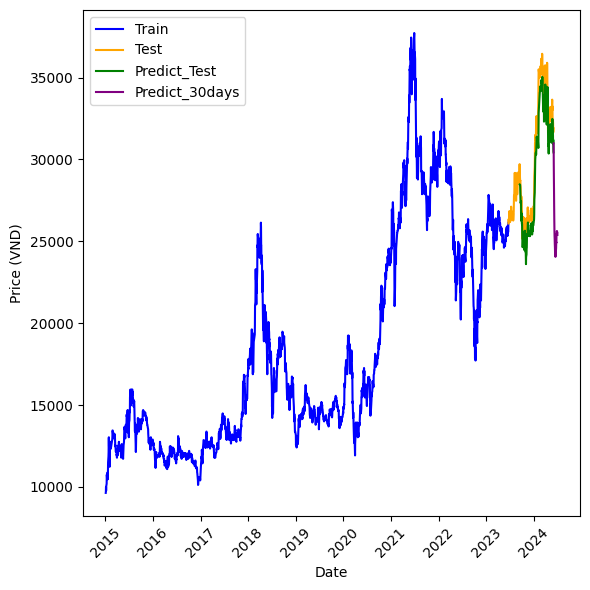

In [6]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('CTG Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu CTG trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu CTG trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  30979.406250
2024-06-02  29797.800781
2024-06-03  28852.250000
2024-06-04  28080.025391
2024-06-05  27126.464844
...                  ...
2024-08-25  19135.650391
2024-08-26  19152.720703
2024-08-27  19116.943359
2024-08-28  19064.121094
2024-08-29  19043.666016

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1206.2961975167832
MAPE: 3.5025349847229927 %
MDA: 1071.8672767857142


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (90/10) 
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0249 
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8148e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5365e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5814e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4707e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2688e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1485e-04
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8341e-04
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6937e-04
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3553e-04
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2900e-04
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1966e-04
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9860e-04
Epoch 15/100
65/65 ━━━━━━━━━━━━━━━

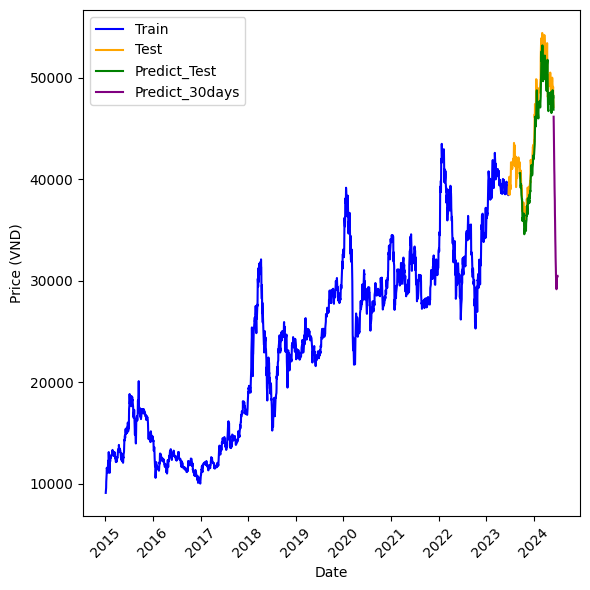

In [10]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('BID Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu BID trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu BID trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  46154.746094
2024-06-02  45285.070312
2024-06-03  44247.308594
2024-06-04  43157.101562
2024-06-05  42100.093750
...                  ...
2024-08-25  19914.978516
2024-08-26  19731.896484
2024-08-27  19506.507812
2024-08-28  19264.734375
2024-08-29  18931.552734

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1481.318739341012
MAPE: 2.7229262787246853 %
MDA: 1253.3742410714287
